## VAE on Faces: Sampling + Latent Space Exploration (CPU-Friendly)

In this session we use a **pretrained VAE on faces** (stabilityai/sd-vae-ft-mse) so everything runs smoothly on **CPU** without training.

We focus on just **two highly visual activities**:

1. **Sampling new faces**  
   - Draw latent vectors from a Gaussian.  
   - Decode them to generate novel face images.  
   - Explore different sampling temperatures for realism vs. creativity.

2. **Exploring the latent space**  
   - **Interpolation:** morph smoothly between two real faces by interpolating their latent vectors.  
   - **Latent sliders:** vary selected latent dimensions to see how traits (pose, lighting, expression) change.

5. Write explanatory notes as a helpful and kind teacher. Never assume the student knows everything. 
6. Reuse what you can from the src/cvcourse repo. Data may already be downloaded in data dir, otherwise download again.

This keeps the session simple, fast, and visually intuitive while showing the core strengths of VAEs.


In [1]:
import sys
from pathlib import Path
from typing import Optional, Sequence

import matplotlib.pyplot as plt
import requests
import torch
import torchvision.transforms.functional as TF
from PIL import Image

ROOT = Path.cwd()
if not (ROOT / "src").exists():
    for parent in ROOT.parents:
        if (parent / "src").exists():
            ROOT = parent
            break
SRC_PATH = ROOT / "src"
if SRC_PATH.exists() and str(SRC_PATH) not in sys.path:
    sys.path.append(str(SRC_PATH))

from cvcourse.utils.device import get_device
from cvcourse.viz.images import show_batch, show_image

plt.rcParams["figure.dpi"] = 110

torch.manual_seed(7)
device = get_device(allow_gpu=False)

LATENT_CHANNELS = 4
LATENT_SPATIAL = 32  # 32*8 -> 256 px outputs
SCALE_FACTOR = 0.18215  # Stable Diffusion latent scaling constant
FACE_DIR = ROOT / "data" / "face_samples"

/Users/mishra/LM/projects/computer-vision-cas-hslu-2025/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Load the Stable Diffusion VAE from Hugging Face

The weights `stabilityai/sd-vae-ft-mse` live on the Hugging Face Hub. We only need the decoder/encoder components, so loading it once and keeping it on CPU is perfectly fine for these visual demos.

In [2]:
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained(
    "stabilityai/sd-vae-ft-mse",
    torch_dtype=torch.float32,
    cache_dir=(ROOT / ".hf-cache"),
)
vae = vae.to(device)
vae.eval()
vae.requires_grad_(False)


def decode_latents(latents: torch.Tensor) -> torch.Tensor:
    """Decode latent tensors into images in [0, 1]."""

    latents = latents.to(device)
    with torch.no_grad():
        images = vae.decode(latents / SCALE_FACTOR).sample
    images = (images.clamp(-1, 1) + 1) / 2
    return images.cpu()


def encode_normalized(images: torch.Tensor) -> torch.Tensor:
    """Encode images already scaled to [-1, 1] into latent space."""

    with torch.no_grad():
        posterior = vae.encode(images.to(device)).latent_dist
    return posterior.sample() * SCALE_FACTOR


def sample_latents(
    batch_size: int = 6,
    temperature: float = 1.0,
    spatial: int = LATENT_SPATIAL,
) -> torch.Tensor:
    """Sample Gaussian latents with an adjustable temperature."""

    latents = torch.randn(batch_size, LATENT_CHANNELS, spatial, spatial) * temperature
    return latents.to(torch.float32) * SCALE_FACTOR


def show_faces(batch: torch.Tensor, title: str = None) -> None:
    show_batch(batch, title=title)

/Users/mishra/LM/projects/computer-vision-cas-hslu-2025/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


### 1. Bring in real faces

Drop JPG/PNG portraits into `data/face_samples/` (any resolution works). If the folder is empty, the helper below downloads two sample portraits from the Hugging Face CelebA-aligned dataset so we always have something to play with. Images are resized to 256×256, normalized to [-1, 1], then encoded into the VAE latent space. **Run this cell before any sampling activity so `reference_faces` is available.**

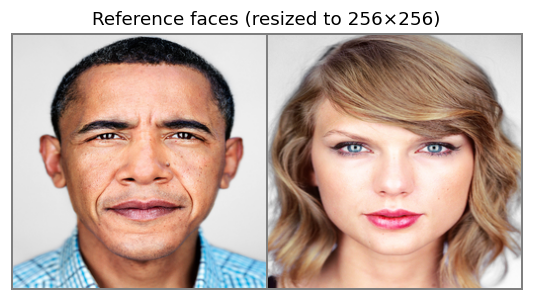

Using faces from:
 • data/face_samples/obama.jpeg
 • data/face_samples/taylor.jpeg


In [13]:
FALLBACK_FACE_URLS = [
    ("celeb_000001", "https://huggingface.co/datasets/huggan/celeb-a-aligned/resolve/main/data/train/000001.jpg"),
    ("celeb_000002", "https://huggingface.co/datasets/huggan/celeb-a-aligned/resolve/main/data/train/000002.jpg"),
]

RESAMPLE = Image.Resampling.LANCZOS if hasattr(Image, "Resampling") else Image.LANCZOS


def _download_face(name: str, url: str) -> Optional[Path]:
    FACE_DIR.mkdir(parents=True, exist_ok=True)
    destination = FACE_DIR / f"{name}.png"
    if destination.exists():
        return destination
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        destination.write_bytes(response.content)
        print(f"Downloaded fallback face -> {destination.relative_to(ROOT)}")
        return destination
    except Exception as exc:  # pragma: no cover - just a friendly fallback
        print(f"Could not download {url}: {exc}")
        return None


def _gather_face_paths(min_faces: int = 2) -> list[Path]:
    extensions = {".png", ".jpg", ".jpeg"}
    paths: list[Path] = []
    if FACE_DIR.exists():
        paths.extend(sorted(p for p in FACE_DIR.iterdir() if p.suffix.lower() in extensions))
    for name, url in FALLBACK_FACE_URLS:
        if len(paths) >= min_faces:
            break
        downloaded = _download_face(name, url)
        if downloaded and downloaded not in paths:
            paths.append(downloaded)
    return paths[:min_faces]


def load_reference_faces(target_px: int = LATENT_SPATIAL * 8) -> dict:
    paths = _gather_face_paths()
    display_tensors = []
    normalized_tensors = []
    used_paths = []
    for path in paths:
        try:
            image = Image.open(path).convert("RGB").resize((target_px, target_px), RESAMPLE)
        except Exception as exc:
            print(f"Skipping {path.name}: {exc}")
            continue
        tensor = TF.to_tensor(image)
        display_tensors.append(tensor)
        normalized_tensors.append(tensor * 2 - 1)
        used_paths.append(path)
    if display_tensors:
        display_batch = torch.stack(display_tensors)
        normalized_batch = torch.stack(normalized_tensors)
        latents = encode_normalized(normalized_batch)
        return {
            "display": display_batch,
            "normalized": normalized_batch,
            "latents": latents,
            "paths": used_paths,
            "source": "images",
        }
    synthetic_latents = sample_latents(batch_size=2, temperature=0.9)
    synthetic_images = decode_latents(synthetic_latents)
    return {
        "display": synthetic_images,
        "normalized": synthetic_images * 2 - 1,
        "latents": synthetic_latents,
        "paths": [],
        "source": "synthetic",
    }


reference_faces = load_reference_faces()
show_faces(reference_faces["display"], title="Reference faces (resized to 256×256)")
if reference_faces["paths"]:
    print("Using faces from:")
    for path in reference_faces["paths"]:
        print(f" • {path.relative_to(ROOT)}")
else:
    print("Using synthetic faces because no local portraits were found.")

### 2. Sampling new faces

Earlier we tried decoding pure Gaussian noise, but this VAE expects latents coming from Stable Diffusion’s U-Net, so random noise alone looks like texture blobs. A simple fix is to **sample around real latents**: encode a few real portraits (previous cell), then add gentle Gaussian noise to them. Edit the parameter cell below, run it, and re-execute the sampling cell whenever you want new results.

In [14]:
def sample_and_visualize(
    batch_size: int = 6,
    temperature: float = 0.7,
    reference_latents: Optional[torch.Tensor] = None,
    reference_noise_scale: float = 0.35,
) -> torch.Tensor:
    """Decode either pure Gaussian latents or reference-conditioned ones."""

    if reference_latents is None or reference_latents.numel() == 0:
        latents = sample_latents(batch_size=batch_size, temperature=temperature, spatial=LATENT_SPATIAL)
    else:
        indices = torch.randint(0, reference_latents.size(0), (batch_size,), device=reference_latents.device)
        base = reference_latents[indices]
        noise = torch.randn_like(base) * (reference_noise_scale * temperature)
        latents = base + noise * SCALE_FACTOR
    faces = decode_latents(latents)
    show_faces(faces, title=f"{batch_size} samples | temp={temperature:.2f}")
    return faces

In [20]:
# 👇 Edit these numbers, re-run this cell, then execute the next cell to resample
SAMPLING_BATCH_SIZE = 8
SAMPLING_TEMPERATURE = 1.5
SAMPLING_USE_REFERENCE = True
SAMPLING_REFERENCE_NOISE = 0.5

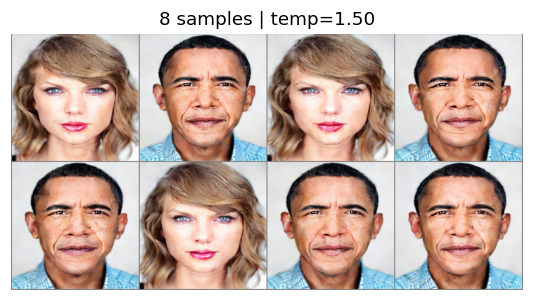

In [21]:
sampling_reference_latents = reference_faces["latents"] if SAMPLING_USE_REFERENCE else None
sampled_faces = sample_and_visualize(
    batch_size=SAMPLING_BATCH_SIZE,
    temperature=SAMPLING_TEMPERATURE,
    reference_latents=sampling_reference_latents,
    reference_noise_scale=SAMPLING_REFERENCE_NOISE,
)

### 3. Interpolate between two faces

Encoding converts each face into a latent code. A straight line in this latent space often yields smooth visual morphs. We interpolate between Face A and Face B, decode every step, and plot them from left to right so you can watch expressions, pose, and lighting blend.

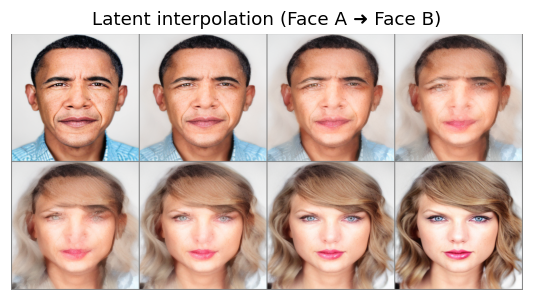

In [22]:
def interpolate_faces(latents: torch.Tensor, steps: int = 7) -> torch.Tensor:
    if latents.size(0) < 2:
        raise ValueError("Need at least two faces to interpolate.")
    start, end = latents[0], latents[1]
    alphas = torch.linspace(0.0, 1.0, steps)
    blended = torch.stack([(1 - alpha) * start + alpha * end for alpha in alphas])
    faces = decode_latents(blended)
    show_faces(faces, title="Latent interpolation (Face A ➜ Face B)")
    return faces


_ = interpolate_faces(reference_faces["latents"], steps=8)

### 4. Latent knobs as a 2D grid

Instead of one slider per direction, we now **pick two latent directions** and sweep them like X/Y axes. One axis nudges trait A, the other trait B. These traits are not guaranteed (VAEs are unsupervised), but choosing meaningful directions—like the difference between two specific faces—often reveals clear changes. Adjust the axis definitions and grid parameters, rerun the config cell, then render the grid to see how the face morphs across both traits simultaneously.

In [32]:
def _normalize_direction(direction: torch.Tensor) -> torch.Tensor:
    norm = direction.flatten().norm()
    return direction / norm.clamp_min(1e-6)


def direction_from_faces(idx_a: int, idx_b: int) -> torch.Tensor:
    latents = reference_faces["latents"].to(device)
    direction = latents[idx_b : idx_b + 1] - latents[idx_a : idx_a + 1]
    return _normalize_direction(direction.squeeze(0))


def random_direction(seed: Optional[int] = None) -> torch.Tensor:
    generator = torch.Generator(device=device)
    if seed is not None:
        generator.manual_seed(seed)
    direction = torch.randn(1, LATENT_CHANNELS, LATENT_SPATIAL, LATENT_SPATIAL, generator=generator, device=device)
    return _normalize_direction(direction.squeeze(0))


def build_direction(mode: str, *, faces: Optional[tuple[int, int]] = None, seed: Optional[int] = None) -> torch.Tensor:
    if mode == "faces":
        if faces is None:
            raise ValueError("Provide a tuple of face indices when mode='faces'.")
        return direction_from_faces(*faces)
    if mode == "random":
        return random_direction(seed=seed)
    raise ValueError("mode must be either 'faces' or 'random'")


def render_latent_grid(
    rows: int,
    cols: int,
    axis_a_range: float,
    axis_b_range: float,
    base_latent: torch.Tensor,
    directions: torch.Tensor,
    step_scale: float,
    axis_labels: tuple[str, str] = ("dir 1", "dir 2"),
) -> torch.Tensor:
    """Visualize how two latent directions change a face over a 2D grid with labeled axes."""

    if directions.size(0) != 2:
        raise ValueError("Need exactly two latent directions to render a grid.")

    a_values = torch.linspace(-axis_a_range, axis_a_range, cols, device=base_latent.device)
    b_values = torch.linspace(axis_b_range, -axis_b_range, rows, device=base_latent.device)
    latents = []
    dir_a, dir_b = directions[0], directions[1]

    for b in b_values:
        for a in a_values:
            latent = base_latent.clone()
            latent = latent + (
                a * dir_a.unsqueeze(0) * step_scale * SCALE_FACTOR
                + b * dir_b.unsqueeze(0) * step_scale * SCALE_FACTOR
            )
            latents.append(latent)

    stacked_latents = torch.cat(latents, dim=0)
    faces = decode_latents(stacked_latents)

    faces_np = faces.permute(0, 2, 3, 1).cpu().numpy()
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.3, rows * 1.3))
    idx = 0
    for r in range(rows):
        for c in range(cols):
            axes[r, c].imshow(faces_np[idx])
            axes[r, c].axis("off")
            if c == 0:
                axes[r, c].set_ylabel(f"{b_values[r].item():+.1f}", rotation=0, labelpad=30, fontsize=9, va="center")
            if r == rows - 1:
                axes[r, c].set_xlabel(f"{a_values[c].item():+.1f}", fontsize=9)
            idx += 1
    fig.supxlabel(f"{axis_labels[0]} scale [-{axis_a_range}, +{axis_a_range}]")
    fig.supylabel(f"{axis_labels[1]} scale [-{axis_b_range}, +{axis_b_range}]")
    fig.suptitle("Latent grid")
    fig.tight_layout()
    plt.show()
    return faces

In [56]:
# 👇 Configure axis directions (choose between 'faces' or 'random')
AXIS_A_MODE = "faces"
AXIS_A_FACES = (0, 1)  # Face idx B minus idx A when mode='faces'
AXIS_A_RANDOM_SEED = 7
AXIS_A_LABEL = "Face difference"  # purely descriptive, change as you see fit

AXIS_B_MODE = "random"
AXIS_B_FACES = (1, 0)
AXIS_B_RANDOM_SEED = 41
AXIS_B_LABEL = "Random variation"

axis_a_direction = build_direction(AXIS_A_MODE, faces=AXIS_A_FACES, seed=AXIS_A_RANDOM_SEED)
axis_b_direction = build_direction(AXIS_B_MODE, faces=AXIS_B_FACES, seed=AXIS_B_RANDOM_SEED)
LATENT_DIRECTIONS = torch.stack([axis_a_direction, axis_b_direction])
LATENT_AXIS_LABELS = (AXIS_A_LABEL, AXIS_B_LABEL)

# 👇 Configure the grid and base face
LATENT_GRID_ROWS = 5
LATENT_GRID_COLS = 5
LATENT_AXIS_A_RANGE = 2.0  # Reduced range for better control
LATENT_AXIS_B_RANGE = 2.0
LATENT_BASE_INDEX = 0  # Use first face (safe if only 2 faces available)
LATENT_GRID_STEP_SCALE = 75  # 🔥 INCREASED from 0.45 to 2.5 for visible changes!
BASE_LATENT = reference_faces["latents"][LATENT_BASE_INDEX : LATENT_BASE_INDEX + 1]

print(
    "Directions ready. Axis A:", AXIS_A_LABEL,
    "| Axis B:", AXIS_B_LABEL,
    "| Base face index:", LATENT_BASE_INDEX,
    f"| Step scale: {LATENT_GRID_STEP_SCALE}",
)
print(f"💡 TIP: If changes are too subtle, increase LATENT_GRID_STEP_SCALE (currently {LATENT_GRID_STEP_SCALE}).")
print(f"💡 TIP: If changes are too extreme, decrease LATENT_GRID_STEP_SCALE or reduce the axis ranges.")

Directions ready. Axis A: Face difference | Axis B: Random variation | Base face index: 0 | Step scale: 75
💡 TIP: If changes are too subtle, increase LATENT_GRID_STEP_SCALE (currently 75).
💡 TIP: If changes are too extreme, decrease LATENT_GRID_STEP_SCALE or reduce the axis ranges.


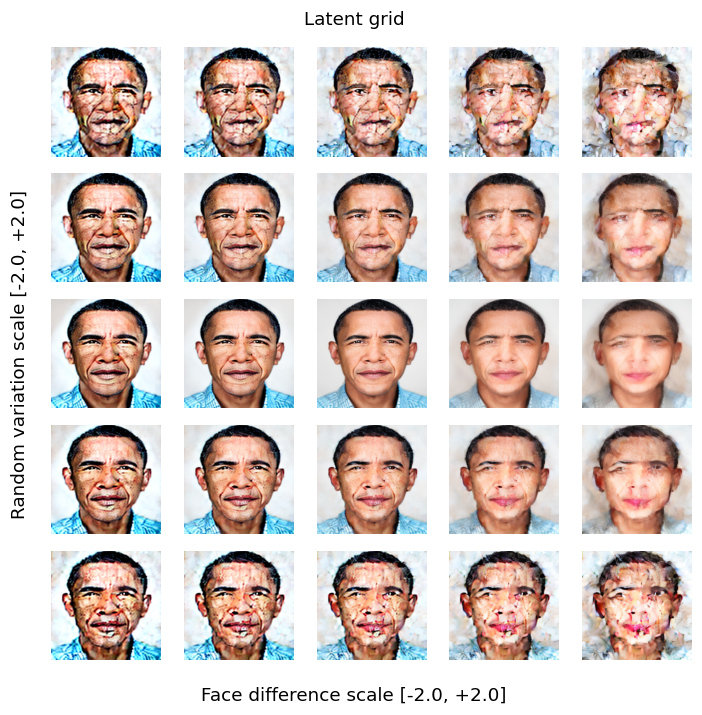

In [57]:
BASE_LATENT = reference_faces["latents"][LATENT_BASE_INDEX : LATENT_BASE_INDEX + 1]
GRID_FACES = render_latent_grid(
    rows=LATENT_GRID_ROWS,
    cols=LATENT_GRID_COLS,
    axis_a_range=LATENT_AXIS_A_RANGE,
    axis_b_range=LATENT_AXIS_B_RANGE,
    base_latent=BASE_LATENT,
    directions=LATENT_DIRECTIONS,
    step_scale=LATENT_GRID_STEP_SCALE,
    axis_labels=LATENT_AXIS_LABELS,
)